In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ctypes
import time
from tqdm import tqdm

rseed = 33

# Problem 1

## Working with provided data
I solved this problem by looking at the data from different angles. I programmed rotating picture of the data with given elevation to speed up the process. I have been checking elevations with step 2 degrees. It turned out, that set of planes can be seen in the range from $\approx 4$ to $\approx 8$ degrees, but the best view comes from elevation $\approx 6.5$.

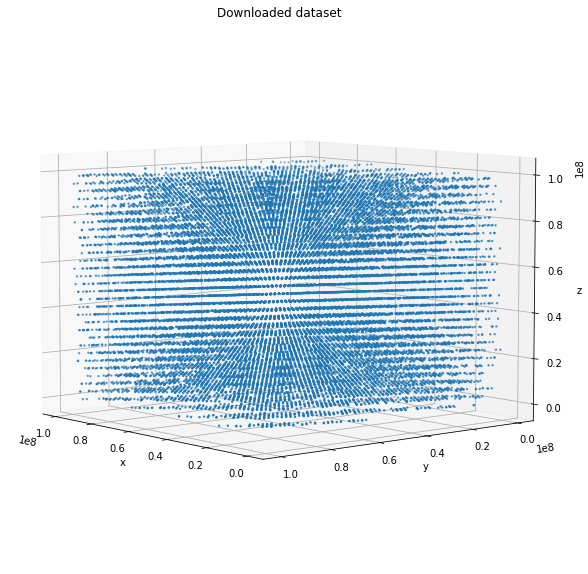

In [2]:
# Reading downloaded file
x, y, z = np.loadtxt('rand_points.txt', unpack=True)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, s=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title("Downloaded dataset")
ax.view_init(6.5, 140)
plt.savefig("p1_dset.png")

# I used this code to 'explore' the data by rotating it in real time (does not work in JN)

# for angle in range(0, 360):
#     ax.view_init(6, angle)
#     plt.draw()
#     plt.pause(.001)

## Generating my own data
I found only the `libc.so.6` in my system (Ubuntu 20.04) which is (probably) the newest version of `libc.so`. Applying the same algorithm as in the previous part, I was not able to observe the same set of planes (I have checked all elevations from 0 to 90 with step 2 degrees). My guess is that the newer version of the library has this 'bug' fixed, but I could not find the confirmation for it on the internet. 

In [129]:
mylib=ctypes.cdll.LoadLibrary("/usr/lib/x86_64-linux-gnu/libc.so.6")
rand=mylib.rand
rand.argtypes=[]
rand.restype=ctypes.c_int

def get_rands_nb(vals):
    n=len(vals)
    for i in tqdm(range(n)):
        vals[i]=rand()
    return vals

def get_rands(n):
    vec=np.empty(n,dtype='int32')
    get_rands_nb(vec)
    return vec


n=300000000
vec=get_rands(n*3)

vv=np.reshape(vec,[n,3])
vmax=np.max(vv,axis=1)

maxval=1e8
vv2=vv[vmax<maxval,:]

f=open('rand_points_my.txt','w')
for i in range(vv2.shape[0]):
    myline=repr(vv2[i,0])+' '+repr(vv2[i,1])+' '+ repr(vv2[i,2])+'\n'
    f.write(myline)
f.close()

100%|██████████████████████████| 900000000/900000000 [04:01<00:00, 3730048.11it/s]


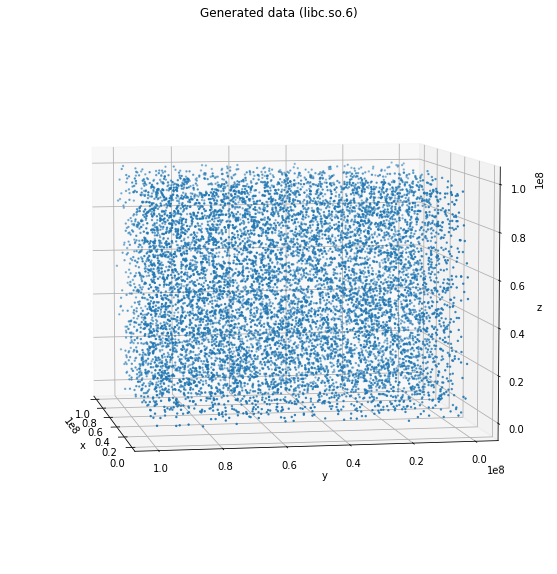

In [103]:
x, y, z = np.loadtxt('rand_points_my.txt', unpack=True)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:10000], y[:10000], z[:10000], s=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(6.5, 170)
plt.title("Generated data (libc.so.6)")
plt.savefig("p1_gset.png")

## Generating data with numpy
For generating random numbers in python I used `numpy.random.randint`. Once again I applied the same algorithm looking for the plains, but was not able to observe them. Looks like I am dealing with some qualitatively written RNGR. :)

P.S. Numpy spent much less time generating the same amount of random points. I think that in the case of using `libc.so.6` most of the execution time is spent on python wrappers. Probably it would be much faster if we write those wrappers in C, compile them to a shared library, and use that function in python.

In [3]:
%%time
np.random.seed(rseed)
n=300000000
x = np.random.randint(0, 2**31-1, size=n, dtype='int32')
y = np.random.randint(0, 2**31-1, size=n, dtype='int32')
z = np.random.randint(0, 2**31-1, size=n, dtype='int32')

CPU times: user 1.81 s, sys: 170 ms, total: 1.98 s
Wall time: 1.98 s


In [4]:
a = np.array([x,y,z]).reshape((-1, 3))
maxval = 1e8
vmax=np.max(a, axis=1)
a2 = a[vmax < maxval, :]
np.save('rand_points_np.npy', a2)

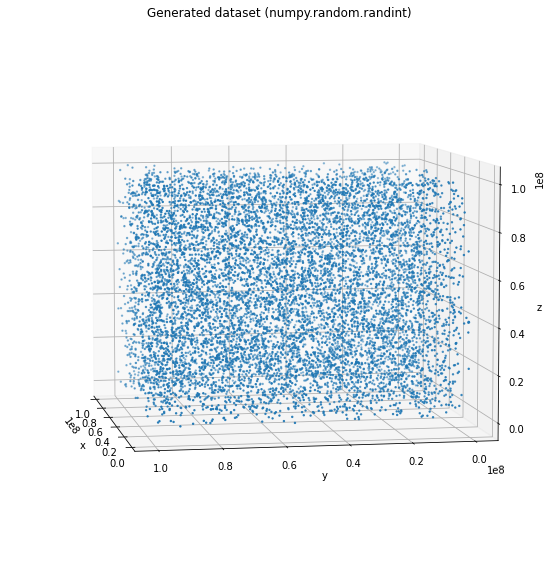

In [5]:
with open('rand_points_np.npy', 'rb') as f:
    a = np.load(f)
    x, y, z = a[:, 0], a[:, 1], a[:, 2]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:10000], y[:10000], z[:10000], s=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(6.5, 170)
plt.title("Generated dataset (numpy.random.randint)")
plt.savefig("p1_nset.png")

# Problem 2
1) There is no point in using Gaussian for rejection sampling because it does not have the explicit cumulative distribution function. Of course, we can brute force it (calculate the integral), but it will be much slower. It is even better to brute force the exponent directly, so we don't spend computational time on potentially rejected points.

2) Power law has its analytical solution for CDF, but it goes to infinity when $t\rightarrow0$. It leads to a waste of generated points because the exponent is limited by 1 on $x=0$ and most of the points for exponent should be generated near $x=0$, but in the case of power law generated points will lie in the interval $[0, \infty]$ which decreases efficiency by much.

3) Lorentzian fits here the most. It even has the same limit as the exponent when $x\rightarrow0$, which improves efficiency. The exponent goes to infinity faster than Lorentzian (I did check it, but do not provide the proof here). The only problem is to make sure that Lorentzian is bigger than the exponent for the whole range of $x$ and I did not manage to derive the coefficient before Lorentzian for this constrain to be true. But for $\alpha = -1$ it looks OK, at least from the plot.

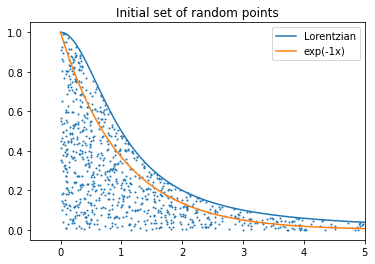

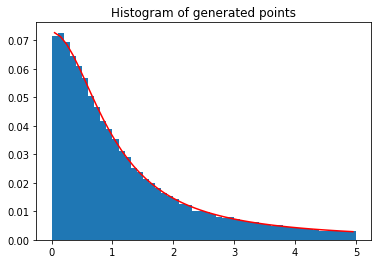

Acceptance rate:	 0.6375


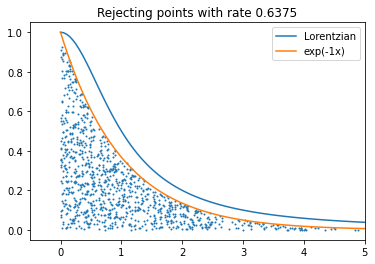

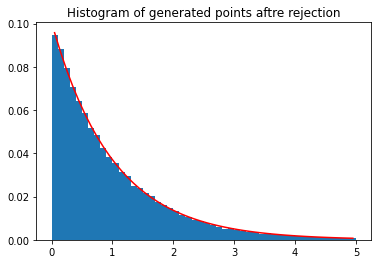

In [14]:
np.random.seed(rseed)

def lorentz_s(n):
    q = np.pi * (np.random.rand(n) - 0.5)
    return np.tan(q)

def lorentz(x):
    return 1 / (1 + x**2)

alpha = -1
dexp = lambda x: np.exp(alpha * x)

n = 100000
xls = np.linspace(0, 5, 100)
t = np.abs(lorentz_s(n))
y = lorentz(t) * np.random.rand(n)

plt.scatter(t[:1000], y[:1000], s=1)
plt.plot(xls, lorentz(xls), label='Lorentzian')
plt.plot(xls, dexp(xls), label=f'exp({alpha}x)')
plt.xlim(-0.5, 5)
plt.legend()
plt.title("Initial set of random points")
plt.savefig("rej_samp.png")
plt.show()

bins = np.linspace(0, 5, 51)
hist, bin_edges = np.histogram(t, bins)
hist = hist / hist.sum()

cents = 0.5 * (bins[1:] + bins[:-1])
pred = 1 / (1 + cents**2)
pred = pred / pred.sum()
plt.clf()
plt.bar(cents, hist, width=cents[1]-cents[0])
plt.plot(cents, pred, 'r')
plt.title("Histogram of generated points")
plt.savefig("hist_samp.png")
plt.show()


accept = y < dexp(t)
print("Acceptance rate:\t", accept.sum() / n)

plt.clf()
plt.scatter(t[accept][:1000], y[accept][:1000], s=1)
plt.plot(xls, lorentz(xls), label='Lorentzian')
plt.plot(xls, dexp(xls), label=f'exp({alpha}x)')
plt.xlim(-0.5, 5)
plt.legend()
plt.title(f"Rejecting points with rate {accept.sum() / n}")
plt.savefig("rej_samp_acc.png")
plt.show()

bins = np.linspace(0, 5, 51)
hist, bin_edges = np.histogram(t[accept], bins)
hist = hist / hist.sum()

cents = 0.5 * (bins[1:] + bins[:-1])
pred = dexp(cents)
pred = pred / pred.sum()
plt.clf()
plt.bar(cents, hist, width=cents[1]-cents[0])
plt.plot(cents, pred, 'r')
plt.title("Histogram of generated points aftre rejection")
plt.savefig("hist_rej.png")
plt.show()

# Problem 3

Max value of v:	 0.7357588428385198
Acceptance rate:	 0.679034


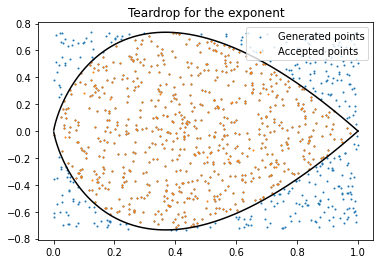

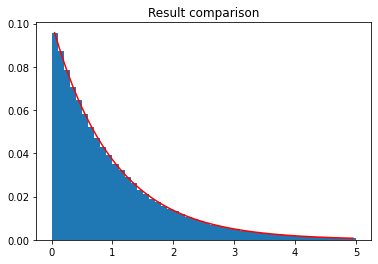

In [13]:
np.random.seed(rseed)
alpha = -1
dexp = lambda x: np.exp(alpha * x)

u=np.linspace(0,1,2001)
u=u[1:]
# u < sqrt(exp(alpha * r))
# log(u**2) = alpha(v / u)
# v = u * log(u**2) / alpha

v = u * np.log(u**2) / alpha
v_max = v.max()

print("Max value of v:\t", v_max)

plt.figure(1)
plt.clf()
plt.plot(u, v, 'k')
plt.plot(u, -v, 'k')

N = 1000000
u = np.random.rand(N)
v = (np.random.rand(N) * 2 - 1) * v_max
r = np.abs(v / u)

plt.scatter(u[:1000], v[:1000], s=1, label='Generated points')

accept = u < np.sqrt(dexp(r))
acc_rat = accept.sum() / N
print("Acceptance rate:\t", acc_rat)

plt.scatter(u[accept][:int(1000 * acc_rat)], v[accept][:int(1000 * acc_rat)], s=1, label='Accepted points')
plt.legend()
plt.title("Teardrop for the exponent")
plt.savefig('exp_teardrop.png')
plt.show()

bins = np.linspace(0, 5, 51)
hist, bin_edges = np.histogram(r[accept], bins)
hist = hist / hist.sum()

cents = 0.5 * (bins[1:] + bins[:-1])
pred = dexp(cents)
pred = pred / pred.sum()

plt.clf()
plt.bar(cents, hist, width=cents[1]-cents[0], label='Final distribution of points')
plt.plot(cents, pred, 'r', label='Prediction')
plt.title("Result comparison")
plt.savefig('exp_teardrop.png')
plt.show()